# Trento course code

## Load packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat

# Day 2 

## 1DSWE

### Functions

In [2]:
def Phi(hstar, hi):
    g = 9.81 # Gravitational constant
    if hstar <= hi:
        # Shock wave
        F = 2 * (np.sqrt(g * hstar) - np.sqrt(g * hi))
    else:
        # Rarefaction wave
        F = np.sqrt(0.5 * g * (hstar + hi) / (hstar * hi)) * (hstar - hi)

    return F


def G(hstar, hL, hR, uL, uR):
    return Phi(hstar, hL) + Phi(hstar, hR) + uR - uL

def dG(hstar, hL, hR, uL, uR):
    eps = 1e-8

    # Compute the finite difference
    res = (G(hstar + eps, hL, hR, uL, uR) - G(hstar - eps, hL, hR, uL, uR)) / (2 * eps)

    return res

def f(q, g):
    F = np.zeros(2)  # Create an array of zeros with size 2
    F[0] = q[1]  # h * u
    F[1] = (q[1] ** 2) / q[0] + 0.5 * g * (q[0] ** 2)  # h * u^2 + 1/2 * g * h^2
    
    return F

def Lambda(q, Nx, g):
    u = q[1, :] / q[0, :]  # Velocity u
    h = q[0, :]            # Height h

    L = np.zeros((2, Nx))  # Create a 2xNx array of zeros
    L[0, :] = u - np.sqrt(g * h)  # L1 = u - sqrt(g * h)
    L[1, :] = u + np.sqrt(g * h)  # L2 = u + sqrt(g * h)

    return L

def Newton(hL, hR, uL, uR, g):
    tol = 1e-10
    hstar = (hL + hR) / 2
    MaxIter = 100

    for i in range(MaxIter):
        residual = G(hstar, hL, hR, uL, uR)  
        if abs(residual) < tol:
            break

        dhstar = -residual / dG(hstar, hL, hR, uL, uR)  
        d = 1

        # Optimization of the Newton method
        for inner in range(MaxIter):
            if abs(G(hstar + d * dhstar, hL, hR, uL, uR)) >= abs(residual):
                # Residual is growing - NOT good
                d *= 0.5
            else:
                # Residual is decreasing - good
                hstar += d * dhstar
                break

    return hstar


In [3]:
def ExactRP(QL, QR, lambda_val, g):
    # Unpack left and right states
    hL = QL[0]
    hR = QR[0]
    uL = QL[1] / hL
    uR = QR[1] / hR

    # Compute the star solution hstar and ustar
    hstar = Newton(hL, hR, uL, uR, g)  
    ustar = uL - Phi(hstar, hL)

    # Sampling of the left wave
    if lambda_val <= ustar:  # Sampling of the left wave
        if hstar > hL:  # Left wave is a shock
            s = uL - np.sqrt(0.5 * g * hstar / hL * (hstar + hL))
            if lambda_val <= s:
                Q = np.array([hL, hL * uL])
            else:
                Q = np.array([hstar, hstar * ustar])
        else:  # Left wave is a rarefaction
            urw_head = uL - np.sqrt(g * hL)  # Velocity of the head of the rarefaction wave
            urw_tail = ustar - np.sqrt(g * hstar)  # Velocity of the tail of the rarefaction wave
            if lambda_val <= urw_head:
                # x_{i+1/2} is in the QL region
                Q = np.array([hL, hL * uL])
            elif lambda_val >= urw_tail:
                # x_{i+1/2} is in the Qstar region
                Q = np.array([hstar, hstar * ustar])
            else:
                # x_{i+1/2} is in the rarefaction wave
                h = ((uL + 2 * np.sqrt(g * hL) - lambda_val) / 3) ** 2 / g
                Q = np.array([h, h * (lambda_val + np.sqrt(g * h))])

    else:  # Sampling of the right wave
        if hstar > hR:  # Right wave is a shock
            s = uR + np.sqrt(0.5 * g * hstar / hR * (hstar + hR))
            if lambda_val <= s:
                Q = np.array([hstar, hstar * ustar])
            else:
                Q = np.array([hR, hR * uR])
        else:  # Right wave is a rarefaction
            urw_head = uR + np.sqrt(g * hR)  # Velocity of the head of the rarefaction wave
            urw_tail = ustar + np.sqrt(g * hstar)  # Velocity of the tail of the rarefaction wave
            if lambda_val >= urw_head:
                # x_{i+1/2} is in the QL region
                Q = np.array([hR, hR * uR])
            elif lambda_val <= urw_tail:
                # x_{i+1/2} is in the Qstar region
                Q = np.array([hstar, hstar * ustar])
            else:
                # x_{i+1/2} is in the rarefaction wave
                h = ((-uR + 2 * np.sqrt(g * hR) + lambda_val) / 3) ** 2 / g
                Q = np.array([h, h * (lambda_val - np.sqrt(g * h))])

    return Q


### Verify solution

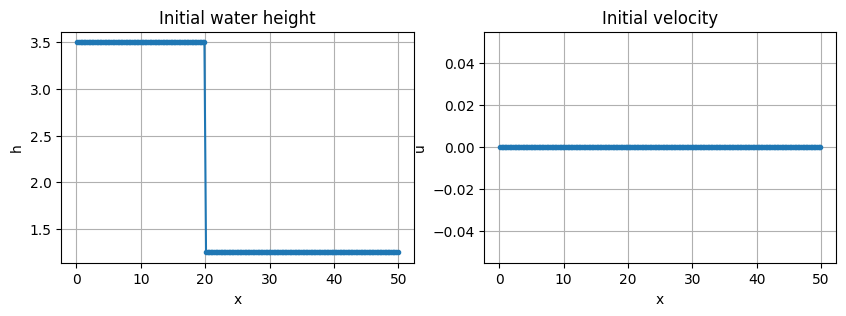

In [4]:
# Physical parameters
xL = 0
xR = 50
t = 0
g = 9.81  # acceleration due to gravity

# Numerical parameters
Nx = 200  # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
CFL = 0.9  # CFL number <= 1
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
q = np.zeros((2, Nx))
hL = 3.5
hR = 1.25
#q[0, :Nx//2] = hL
#q[0, Nx//2:] = hR
#q = np.where(x < 20, hL, hR)
q[0, :] = np.where(x < 20, hL, hR)
qnew = q.copy()

# Plot the initial data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title('Initial water height')

plt.subplot(1, 2, 2)
plt.plot(x, q[1, :] / q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title('Initial velocity')

plt.show()

In [5]:
tend = 2.5

# Compute the total amount of water content in the domain (integral of h between xL and xR)
H0 = np.sum(dx * q[0, :])

# Time loop
for n in range(1000000):
    amax = np.max(np.abs(Lambda(q, Nx, g)))
    dt = CFL * dx / amax
    if t + dt > tend:
        dt = tend - t
    if t >= tend:
        break  # Stop the time loop

    # Space loop
    dtdx = dt / dx
    for i in range(Nx):
        if i == 0:
            q_ghost = q[:, i].copy()  # Create a ghost state outside of the domain
            q_ghost[1] = -q[1, i]  # Invert the sign of its momentum/velocity
            qm = ExactRP(q_ghost, q[:, i], 0, g)  # Compute the exact sol of the RP at x_{i-1/2}
            fm = f(qm, g)
            qp = ExactRP(q[:, i], q[:, i + 1], 0, g)  # Compute the exact sol of the RP at x_{i+1/2}
            fp = f(qp, g)
            # Standard Finite-Volume update
            qnew[:, i] = q[:, i] - dtdx * (fp - fm)

        elif i == Nx - 1:
            q_ghost = q[:, i].copy()  # Create a ghost state outside of the domain
            q_ghost[1] = -q[1, i]  # Invert the sign of its momentum/velocity
            qm = ExactRP(q[:, i - 1], q[:, i], 0, g)  # Compute the exact sol of the RP at x_{i-1/2}
            fm = f(qm, g)
            qp = ExactRP(q[:, i], q_ghost, 0, g)  # Compute the exact sol of the RP at x_{i+1/2}
            fp = f(qp, g)
            # Standard Finite-Volume update
            qnew[:, i] = q[:, i] - dtdx * (fp - fm)

        else:
            qm = ExactRP(q[:, i - 1], q[:, i], 0, g)  # Compute the exact sol of the RP at x_{i-1/2}
            fm = f(qm, g)
            qp = ExactRP(q[:, i], q[:, i + 1], 0, g)  # Compute the exact sol of the RP at x_{i+1/2}
            fp = f(qp, g)
            # Standard Finite-Volume update
            qnew[:, i] = q[:, i] - dtdx * (fp - fm)

    # Update time and solution
    t += dt
    q = qnew.copy()


In [6]:
# Load the .mat file
mat_data = loadmat('data/dambreakdata.mat')

h_sol = mat_data['h']
u_sol = mat_data['u']

h_sol = np.array(h_sol[0, :])
u_sol = np.array(u_sol[0, :])

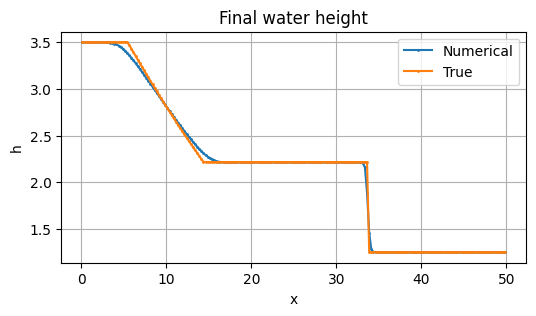

In [7]:
# Plot the final data
plt.figure(figsize=(6, 3))
plt.plot(x, q[0, :], '-o', markersize = 1)
plt.plot(x, h_sol, '-o', markersize = 1)
plt.legend(['Numerical', 'True'])
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title('Final water height')
plt.show()


# Toro test cases

In [8]:
# Save
save = 1

In [9]:
# Define function
def solve_SWE_1D(q, Nx, dx, CFL, g, t, tend):

    qnew = q.copy()

    # Compute the total amount of water content in the domain (integral of h between xL and xR)
    H0 = np.sum(dx * q[0, :])

    # Time loop
    for n in range(1000000):
        amax = np.max(np.abs(Lambda(q, Nx, g)))
        dt = CFL * dx / amax
        if t + dt > tend:
            dt = tend - t
        if t >= tend:
            break  # Stop the time loop

        # Space loop
        dtdx = dt / dx
        for i in range(Nx):
            if i == 0:
                q_ghost = q[:, i].copy()  # Create a ghost state outside of the domain
                q_ghost[1] = -q[1, i]  # Invert the sign of its momentum/velocity
                qm = ExactRP(q_ghost, q[:, i], 0, g)  # Compute the exact sol of the RP at x_{i-1/2}
                fm = f(qm, g)
                qp = ExactRP(q[:, i], q[:, i + 1], 0, g)  # Compute the exact sol of the RP at x_{i+1/2}
                fp = f(qp, g)
                # Standard Finite-Volume update
                qnew[:, i] = q[:, i] - dtdx * (fp - fm)

            elif i == Nx - 1:
                q_ghost = q[:, i].copy()  # Create a ghost state outside of the domain
                q_ghost[1] = -q[1, i]  # Invert the sign of its momentum/velocity
                qm = ExactRP(q[:, i - 1], q[:, i], 0, g)  # Compute the exact sol of the RP at x_{i-1/2}
                fm = f(qm, g)
                qp = ExactRP(q[:, i], q_ghost, 0, g)  # Compute the exact sol of the RP at x_{i+1/2}
                fp = f(qp, g)
                # Standard Finite-Volume update
                qnew[:, i] = q[:, i] - dtdx * (fp - fm)

            else:
                qm = ExactRP(q[:, i - 1], q[:, i], 0, g)  # Compute the exact sol of the RP at x_{i-1/2}
                fm = f(qm, g)
                qp = ExactRP(q[:, i], q[:, i + 1], 0, g)  # Compute the exact sol of the RP at x_{i+1/2}
                fp = f(qp, g)
                # Standard Finite-Volume update
                qnew[:, i] = q[:, i] - dtdx * (fp - fm)

        # Update time and solution
        t += dt
        q = qnew.copy()
    return q


## Test 1

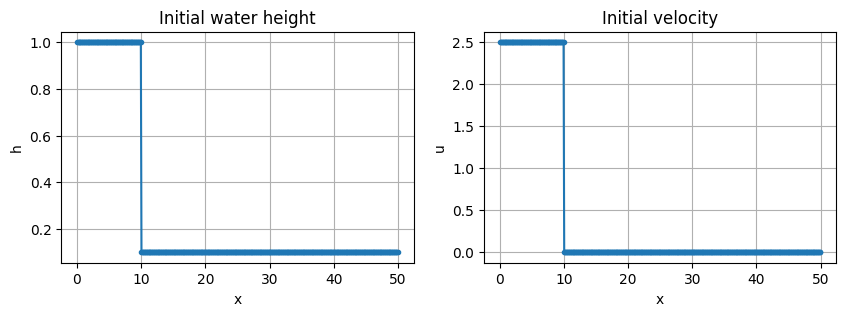

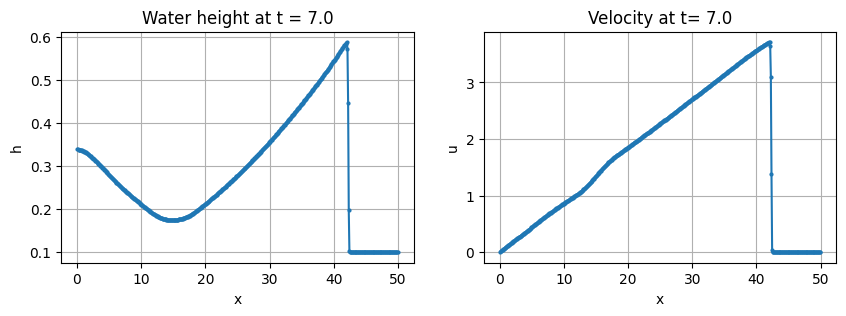

In [10]:
# Physical parameters
xL = 0
xR = 50
t = 0
g = 9.81  # acceleration due to gravity

# Numerical parameters
Nx = 500  # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
CFL = 0.9  # CFL number <= 1
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
q = np.zeros((2, Nx))
hL = 1.0
hR = 0.1
uL = 2.5
uR = 0.0
x0 = 10.0

# Define initial water height and velocity
q[0, :] = np.where(x < x0, hL, hR)           
q[1, :] = np.where(x < x0, hL * uL, hR * uR)

# Plot the initial data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title('Initial water height')

plt.subplot(1, 2, 2)
plt.plot(x, q[1, :] / q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title('Initial velocity')

# Save figure
if save:
    plt.savefig('plots/toro_test1_initial.png')

plt.show()

# Solve the SWE
tend = 7.0
q = solve_SWE_1D(q, Nx, dx, CFL, g, t, tend)

# Plot the final data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, q[0, :], '-o', markersize = 2)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title(f'Water height at t = {tend}')

plt.subplot(1, 2, 2)
plt.plot(x, q[1, :] / q[0, :], '-o', markersize = 2)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title(f'Velocity at t= {tend}')

# Save figure
if save:
    plt.savefig('plots/toro_test1_final.png')

plt.show()


In [11]:
# Load the .mat file
mat_data = loadmat('data/torotest1.mat')
htrue = mat_data['htrue']
utrue = mat_data['utrue']
x = mat_data['x']

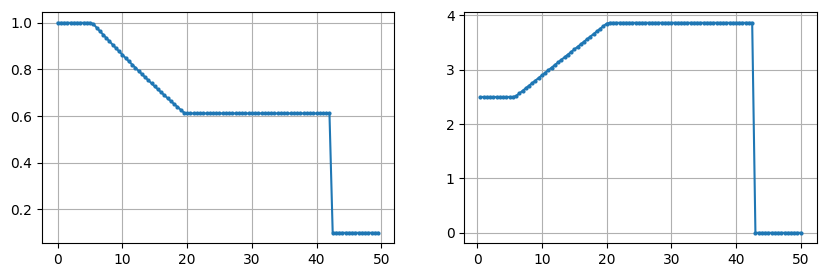

In [12]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(x[0, :], htrue[0, :], '-o', markersize = 2)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x[1, :], utrue[0, :], '-o', markersize = 2)
plt.grid()

plt.show()


## Test 2

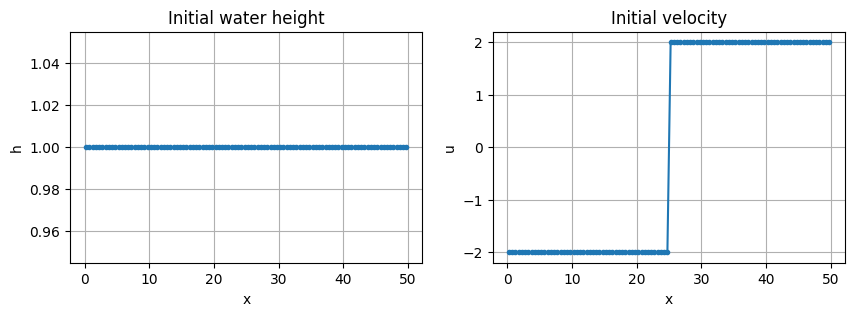

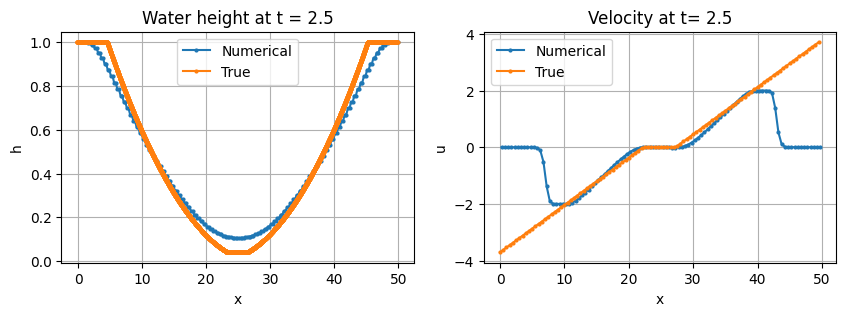

In [69]:
# Physical parameters
xL = 0
xR = 50
t = 0
g = 9.81  # acceleration due to gravity

# Numerical parameters
Nx =  100  # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
CFL = 0.9  # CFL number <= 1
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
q = np.zeros((2, Nx))
hL = 1.0
hR = 1.0
uL = -2
uR = 2
x0 = 25.0

# Define initial water height and velocity
q[0, :] = np.where(x < x0, hL, hR)           
q[1, :] = np.where(x < x0, hL * uL, hR * uR)

# Plot the initial data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title('Initial water height')

plt.subplot(1, 2, 2)
plt.plot(x, q[1, :] / q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title('Initial velocity')

# Save figure
if save:
    plt.savefig('plots/toro_test2_initial.png')

plt.show()

# Solve the SWE
tend = 2.5
q = solve_SWE_1D(q, Nx, dx, CFL, g, t, tend)

# Import the true solution
mat_data = loadmat('data/torotest2.mat')
htrue = mat_data['htrue']
utrue = mat_data['utrue']
xtrue = mat_data['x']

# Import solution from Matlab
mat_data = loadmat('data/torotest2flux2.mat')
xc = mat_data['xc']
h = mat_data['h']
u = mat_data['u']
xexact = mat_data['xexact']
hexact = mat_data['hexact']
uexact = mat_data['uexact']

# Plot the final data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(xc[0,:], h[0,:], '-o', markersize = 2)
plt.plot(xexact[0, :], hexact[0, :], '-o', markersize = 2)
plt.legend(['Numerical', 'True'])
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title(f'Water height at t = {tend}')

plt.subplot(1, 2, 2)
plt.plot(x, q[1, :] / q[0, :], '-o', markersize = 2)
plt.plot(xtrue[0, :], utrue[0, :], '-o', markersize = 2)
plt.legend(['Numerical', 'True'])
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title(f'Velocity at t= {tend}')

# Save figure
if save:
    plt.savefig('plots/toro_test2_final.png')

plt.show()


## Test 3

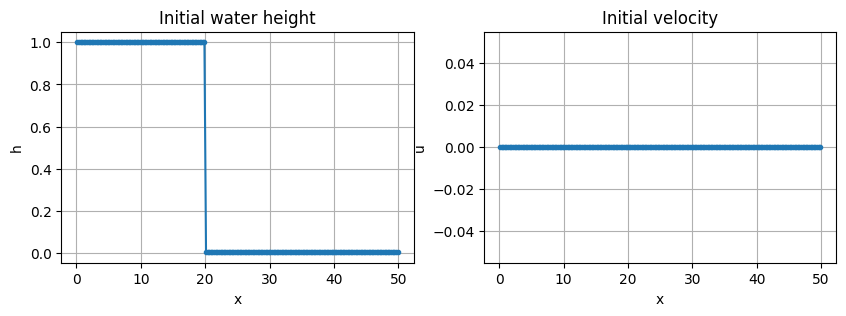

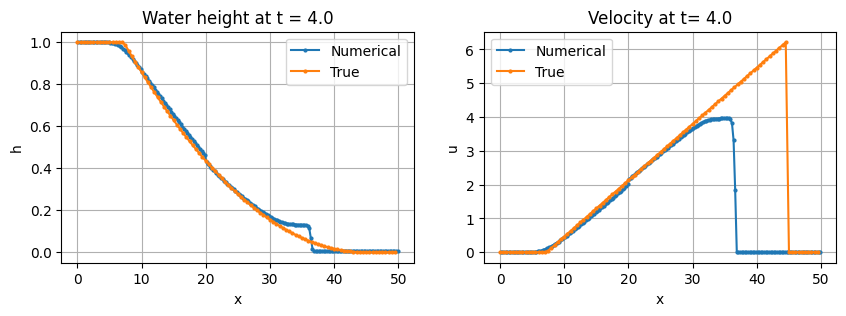

In [14]:
# Physical parameters
xL = 0
xR = 50
g = 9.81  # acceleration due to gravity

# Numerical parameters
Nx = 200  # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
CFL = 0.9  # CFL number <= 1
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
q = np.zeros((2, Nx))
hL = 1.0
hR = 0.005
uL = 0.0
uR = 0.0
x0 = 20.0

# Define initial water height and velocity
q[0, :] = np.where(x < x0, hL, hR)           
q[1, :] = np.where(x < x0, hL * uL, hR * uR)

# Plot the initial data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title('Initial water height')

plt.subplot(1, 2, 2)
plt.plot(x, q[1, :] / q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title('Initial velocity')

# Save figure
if save:
    plt.savefig('plots/toro_test3_initial.png')

plt.show()

# Solve the 1D SWE
tend = 4.0
q = solve_SWE_1D(q, Nx, dx, CFL, g, t, tend)

# Import the true solution
mat_data = loadmat('data/torotest3.mat')
htrue = mat_data['htrue']
utrue = mat_data['utrue']
xtrue = mat_data['x']

# Plot the final data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, q[0, :], '-o', markersize = 2)
plt.plot(xtrue[0, :], htrue[0, :], '-o', markersize = 2)
plt.legend(['Numerical', 'True'])
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title(f'Water height at t = {tend}')

plt.subplot(1, 2, 2)
plt.plot(x, q[1, :] / q[0, :], '-o', markersize = 2)
plt.plot(xtrue[0, :], utrue[0, :], '-o', markersize = 2)
plt.legend(['Numerical', 'True'])
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title(f'Velocity at t= {tend}')

# Save figure
if save:
    plt.savefig('plots/toro_test3_final.png')

plt.show()


## Test 4

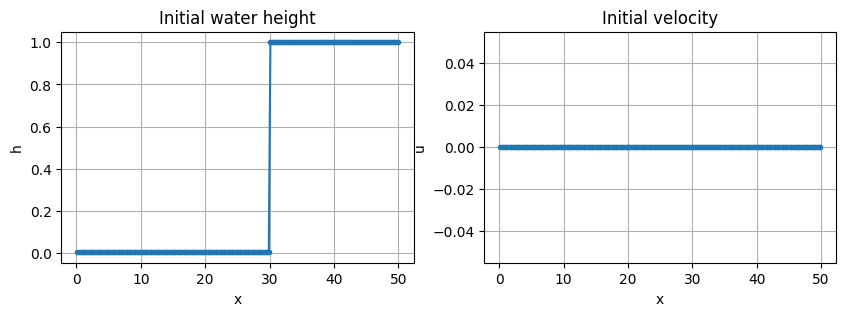

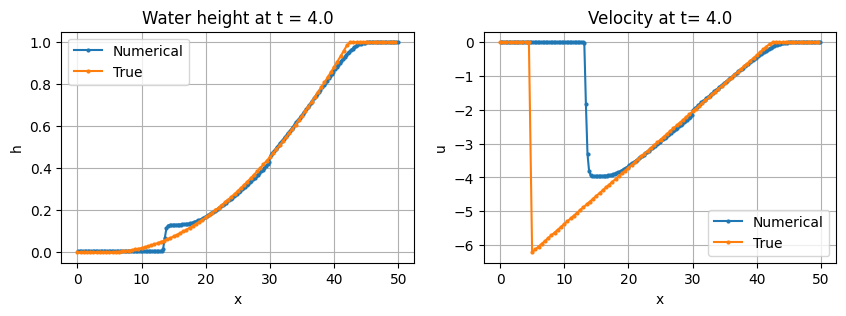

In [15]:
# Physical parameters
xL = 0
xR = 50
t = 0
g = 9.81  # acceleration due to gravity

# Numerical parameters
Nx = 200  # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
CFL = 0.9  # CFL number <= 1
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
q = np.zeros((2, Nx))
hL = 0.005
hR = 1.0
uL = 0.0
uR = 0.0
x0 = 30.0

# Define initial water height and velocity
q[0, :] = np.where(x < x0, hL, hR)           
q[1, :] = np.where(x < x0, hL * uL, hR * uR)

# Plot the initial data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title('Initial water height')

plt.subplot(1, 2, 2)
plt.plot(x, q[1, :] / q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title('Initial velocity')

if save:
    plt.savefig('plots/toro_test4_initial.png')

plt.show()

# Solve the SWE
tend = 4.0
q = solve_SWE_1D(q, Nx, dx, CFL, g, t, tend)

# Import the true solution
mat_data = loadmat('data/torotest4.mat')
htrue = mat_data['htrue']
utrue = mat_data['utrue']
xtrue = mat_data['x']

# Plot the final data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, q[0, :], '-o', markersize = 2)
plt.plot(xtrue[0, :], htrue[0, :], '-o', markersize = 2)
plt.legend(['Numerical', 'True'])
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title(f'Water height at t = {tend}')

plt.subplot(1, 2, 2)
plt.plot(x, q[1, :] / q[0, :], '-o', markersize = 2)
plt.plot(xtrue[0, :], utrue[0, :], '-o', markersize = 2)
plt.legend(['Numerical', 'True'])
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title(f'Velocity at t= {tend}')

if save:
    plt.savefig('plots/toro_test4_final.png')

plt.show()


## Test 5

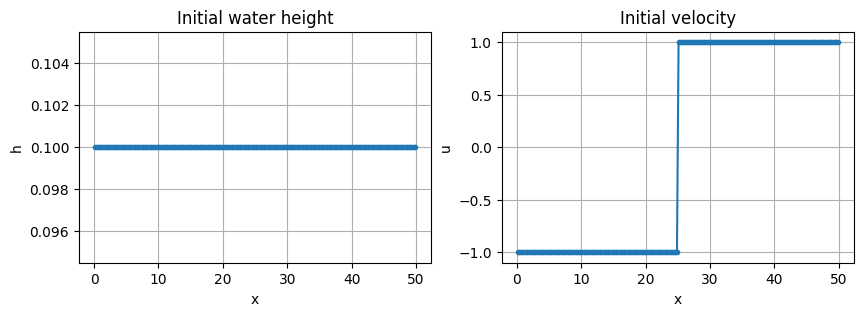

C:\Users\Matteo\AppData\Local\Temp\ipykernel_16128\2691461147.py:5: RuntimeWarning: invalid value encountered in sqrt
  F = 2 * (np.sqrt(g * hstar) - np.sqrt(g * hi))


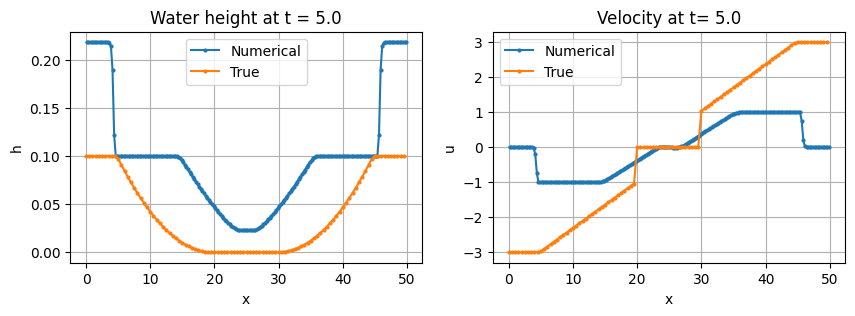

In [16]:
# Physical parameters
xL = 0
xR = 50
t = 0
g = 9.81  # acceleration due to gravity

# Numerical parameters
Nx = 200  # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
CFL = 0.9  # CFL number <= 1
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
q = np.zeros((2, Nx))
hL = 0.1
hR = 0.1
uL = -1.0
uR = 1.0
x0 = 25.0

# Define initial water height and velocity
q[0, :] = np.where(x < x0, hL, hR)           
q[1, :] = np.where(x < x0, hL * uL, hR * uR)

# Plot the initial data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title('Initial water height')

plt.subplot(1, 2, 2)
plt.plot(x, q[1, :] / q[0, :], '-o', markersize = 3)
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title('Initial velocity')

# Save figure
if save:
    plt.savefig('plots/toro_test5_initial.png')

plt.show()

# Solve the SWE
tend = 5.0
q = solve_SWE_1D(q, Nx, dx, CFL, g, t, tend)

# Import the true solution
mat_data = loadmat('data/torotest5.mat')
htrue = mat_data['htrue']
utrue = mat_data['utrue']
xtrue = mat_data['x']

# Plot the final data
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(x, q[0, :], '-o', markersize = 2)
plt.plot(xtrue[0, :], htrue[0, :], '-o', markersize = 2)
plt.legend(['Numerical', 'True'])
plt.grid()
plt.ylabel('h')
plt.xlabel('x')
plt.title(f'Water height at t = {tend}')

plt.subplot(1, 2, 2)
plt.plot(x, q[1, :] / q[0, :], '-o', markersize = 2)
plt.plot(xtrue[0, :], utrue[0, :], '-o', markersize = 2)
plt.legend(['Numerical', 'True'])
plt.grid()
plt.ylabel('u')
plt.xlabel('x')
plt.title(f'Velocity at t= {tend}')

# Save figure
if save:
    plt.savefig('plots/toro_test5_final.png')

plt.show()


# Day 3 - SWE 2D
The MUSCL-Hancock scheme for the 2D SWE with the Rusanov numerical flux.

In [70]:
# Define the global gravity constant
g = 9.81

def FluxX(Q):
    # Initialize F to the same shape as Q
    F = np.zeros_like(Q)

    # Compute the flux in the x-direction    
    F[0, :, :] = Q[1, :, :]
    F[1, :, :] = Q[1, :, :]**2 / Q[0, :, :] + 0.5 * g * Q[0, :, :]**2
    F[2, :, :] = Q[1, :, :] * Q[2, :, :] / Q[0, :, :]

    return F


def FluxY(Q):
    # Initialize G to the same shape as Q
    G = np.zeros_like(Q)

    # Compute the flux in the y-direction
    G[0, :, :] = Q[2, :, :]
    G[1, :, :] = Q[1, :, :] * Q[2, :, :] / Q[0, :, :]
    G[2, :, :] = Q[2, :, :]**2 / Q[0, :, :] + 0.5 * g * Q[0, :, :]**2

    return G

def Lambdax(Q):
    # Initialize L to the same shape as Q
    L = np.zeros_like(Q)

    # Compute velocity and wave speed
    u = Q[1, :, :] / Q[0, :, :]  # u = hu / h
    c = np.sqrt(g * Q[0, :, :])   # c = sqrt(g * h)

    # Characteristic velocities in the x-direction
    L[0, :, :] = u - c
    L[1, :, :] = u
    L[2, :, :] = u + c

    return L

def Lambday(Q):
    # Initialize L to the same shape as Q
    L = np.zeros_like(Q)

    # Compute velocity in y-direction and wave speed
    v = Q[2, :, :] / Q[0, :, :]  # v = hv / h
    c = np.sqrt(g * Q[0, :, :])   # c = sqrt(g * h)

    # Characteristic velocities in the y-direction
    L[0, :, :] = v - c
    L[1, :, :] = v
    L[2, :, :] = v + c

    return L

def minmodarray(a, b):
    nVar, Nx, Ny = a.shape
    c = np.zeros((nVar, Nx, Ny))

    for i in range(nVar):
        # First condition: a * b > 0 and |a| < |b|
        logic1 = (a[i, :, :] * b[i, :, :] > 0) & (np.abs(a[i, :, :]) < np.abs(b[i, :, :]))
        c[i, :, :] = a[i, :, :] * logic1
        
        # Second condition: a * b > 0 and |a| > |b|
        logic2 = (a[i, :, :] * b[i, :, :] > 0) & (np.abs(a[i, :, :]) > np.abs(b[i, :, :]))
        c[i, :, :] += b[i, :, :] * logic2

    return c

def Rusanov(QL, QR, FL, FR, sL, sR):
    smax = np.maximum(np.abs(sL).max(), np.abs(sR).max())
    F = 0.5 * (FR + FL) - 0.5 * smax * (QR - QL)
    return F

def Rusanov(QL, QR, FL, FR, sL, sR):
    smax = np.maximum(np.abs(sL).max(), np.abs(sR).max())
    QL = QL.reshape(3,)
    QR = QR.reshape(3,)
    FL = FL.reshape(3,)
    FR = FR.reshape(3,)
    sL = sL.reshape(3,)
    sR = sR.reshape(3,)
    F = 0.5 * (FR + FL) - 0.5 * smax * (QR - QL)
    return F


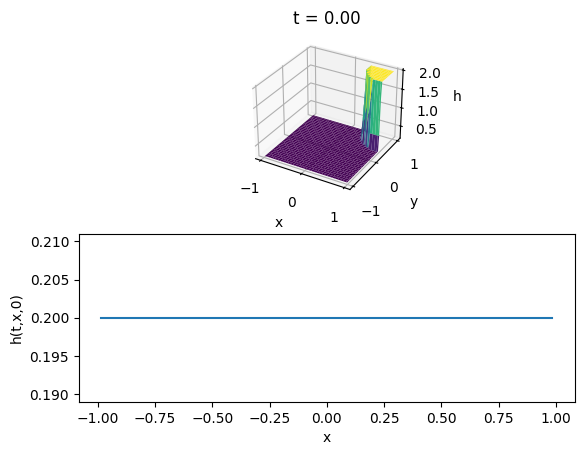

In [71]:
# Global constants
g = 9.81  # gravity
Nx = 64
Ny = Nx
xL, xR = -1, 1
yL, yR = -1, 1
t = 0
tend = 0.05 # 1 
CFL = 0.9

dx = (xR - xL) / Nx
dy = (yR - yL) / Ny

x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)
y = np.linspace(yL + dy / 2, yR - dy / 2, Ny)

# Initial conditions
Q = np.zeros((3, Nx, Ny))
Qnew = np.copy(Q)
for i in range(Nx):
    for j in range(Ny):
        r = np.sqrt((x[i] - 0.9)**2 + (y[j] - 0.9)**2)
        if r < 0.5:
            Q[0, i, j] = 2
        else:
            Q[0, i, j] = 0.2

fig = plt.figure()
ax1 = fig.add_subplot(211, projection='3d')
ax2 = fig.add_subplot(212)

# Time loop
for n in range(100000):
    sx = Lambdax(Q)  # characteristic velocities in x-direction
    sy = Lambday(Q)  # characteristic velocities in y-direction
    ax = np.max(np.abs(sx))
    ay = np.max(np.abs(sy))
    
    dt = CFL / (ax / dx + ay / dy)
    if t + dt > tend:
        dt = tend - t
    if t >= tend:
        break

    # MUSCL part
    slopeX = np.zeros_like(Q)
    slopeY = np.zeros_like(Q)
    
    slopeX[:, 1:Nx-1, :] = minmodarray(Q[:, 1:Nx-1, :] - Q[:, 0:Nx-2, :], Q[:, 2:Nx, :] - Q[:, 1:Nx-1, :])
    slopeY[:, :, 1:Ny-1] = minmodarray(Q[:, :, 1:Ny-1] - Q[:, :, 0:Ny-2], Q[:, :, 2:Ny] - Q[:, :, 1:Ny-1])

    Qxm = Q - 0.5 * slopeX
    Qxp = Q + 0.5 * slopeX
    Qym = Q - 0.5 * slopeY
    Qyp = Q + 0.5 * slopeY

    Q_t = -(FluxX(Qxp) - FluxX(Qxm)) / dx - (FluxY(Qyp) - FluxY(Qym)) / dy
    Qxm += 0.5 * dt * Q_t
    Qxp += 0.5 * dt * Q_t
    Qym += 0.5 * dt * Q_t
    Qyp += 0.5 * dt * Q_t

    # Recompute physical fluxes and characteristic velocities for Rusanov flux
    fxm, fxp = FluxX(Qxm), FluxX(Qxp)
    gym, gyp = FluxY(Qym), FluxY(Qyp)
    
    sxm, sxp = Lambdax(Qxm), Lambdax(Qxp)
    sym, syp = Lambday(Qym), Lambday(Qyp)

    dtdx = dt / dx
    dtdy = dt / dy

    # Space loop
    for i in range(Nx):
        for j in range(Ny):
            # Numerical fluxes in X
            if i == 0:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                Qghost[1] = -Qghost[1]
                Fm = Rusanov(Qghost, Qxm[:, i, j], FluxX(Qghost), fxm[:, i, j], Lambdax(Qghost), sxm[:, i, j])
                Fp = Rusanov(Qxp[:, i, j], Qxm[:, i+1, j], fxp[:, i, j], fxm[:, i+1, j], sxp[:, i, j], sxm[:, i+1, j])
            elif i == Nx - 1:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                Qghost[1] = -Qghost[1]
                Fm = Rusanov(Qxp[:, i-1, j], Qxm[:, i, j], fxp[:, i-1, j], fxm[:, i, j], sxp[:, i-1, j], sxm[:, i, j])
                Fp = Rusanov(Qxp[:, i, j], Qghost, fxp[:, i, j], FluxX(Qghost), sxp[:, i, j], Lambdax(Qghost))
            else:
                Fm = Rusanov(Qxp[:, i-1, j], Qxm[:, i, j], fxp[:, i-1, j], fxm[:, i, j], sxp[:, i-1, j], sxm[:, i, j])
                Fp = Rusanov(Qxp[:, i, j], Qxm[:, i+1, j], fxp[:, i, j], fxm[:, i+1, j], sxp[:, i, j], sxm[:, i+1, j])

            # Numerical fluxes in Y
            if j == 0:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                #Qghost = Q[:, i, j].copy()
                Qghost[2] = -Qghost[2]
                Gm = Rusanov(Qghost, Qym[:, i, j], FluxY(Qghost), gym[:, i, j], Lambday(Qghost), sym[:, i, j])
                Gp = Rusanov(Qyp[:, i, j], Qym[:, i, j+1], gyp[:, i, j], gym[:, i, j+1], syp[:, i, j], sym[:, i, j+1])
            elif j == Ny - 1:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                #Qghost = Q[:, i, j].copy()
                Qghost[2] = -Qghost[2]
                Gm = Rusanov(Qyp[:, i, j-1], Qym[:, i, j], gyp[:, i, j-1], gym[:, i, j], syp[:, i, j-1], sym[:, i, j])
                Gp = Rusanov(Qyp[:, i, j], Qghost, gyp[:, i, j], FluxY(Qghost), syp[:, i, j], Lambday(Qghost))
            else:
                Gm = Rusanov(Qyp[:, i, j-1], Qym[:, i, j], gyp[:, i, j-1], gym[:, i, j], syp[:, i, j-1], sym[:, i, j])
                Gp = Rusanov(Qyp[:, i, j], Qym[:, i, j+1], gyp[:, i, j], gym[:, i, j+1], syp[:, i, j], sym[:, i, j+1])

            # Finite volume update
            Qnew[:, i, j] = Q[:, i, j] - dtdx * (Fp - Fm) - dtdy * (Gp - Gm)

    # Update time and solution
    t += dt
    Q = np.copy(Qnew)

    # Plot the solution
    ax1.clear()
    ax1.plot_surface(np.meshgrid(x, y)[0], np.meshgrid(x, y)[1], Q[0, :, :], cmap='viridis')
    ax1.set_title(f't = {t:.2f}')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('h')

    ax2.clear()
    ax2.plot(x, Q[0, :, Ny // 2])
    ax2.set_xlabel('x')
    ax2.set_ylabel('h(t,x,0)')

    plt.pause(0.1)

plt.show()


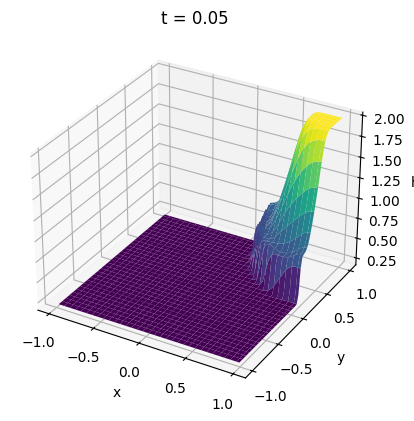

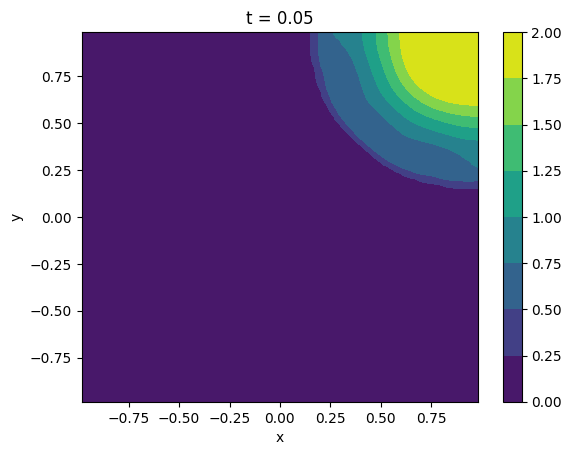

In [72]:
# Plot the final data in 3d and in contour
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(np.meshgrid(x, y)[0], np.meshgrid(x, y)[1], Q[0, :, :], cmap='viridis')
ax.set_title(f't = {t:.2f}')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('h')
plt.show()

plt.figure()
plt.contourf(np.meshgrid(x, y)[0], np.meshgrid(x, y)[1], Q[0, :], cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title(f't = {t:.2f}')
plt.show()



## Idealised dam break 2D

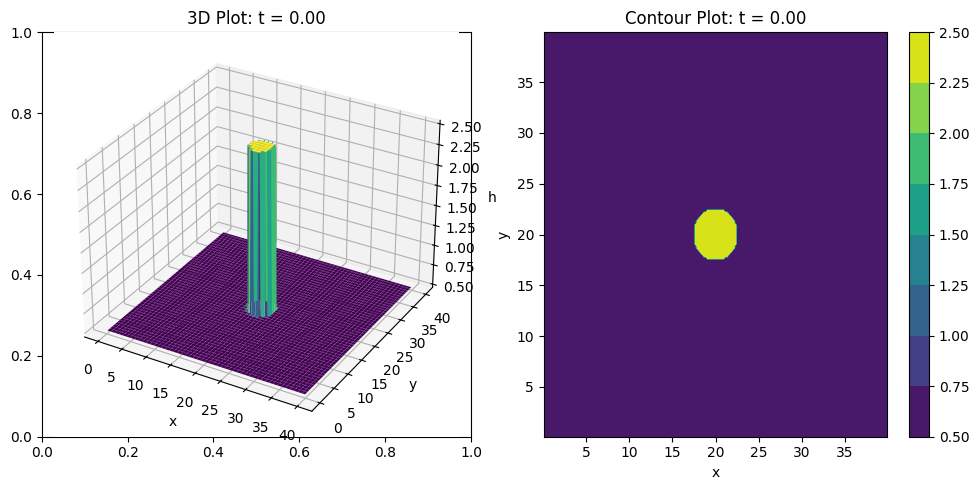

In [122]:
# Global constants
g = 9.81  # gravity
Nx = 200
Ny = Nx
xL, xR = 0, 40
yL, yR = 0, 40
t = 0
tend = 0.7 # 1 
CFL = 0.9

dx = (xR - xL) / Nx
dy = (yR - yL) / Ny

x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)
y = np.linspace(yL + dy / 2, yR - dy / 2, Ny)

# Center
xc = 20
yc = 20

# Radius
R = 2.5

# Initial conditions
Q = np.zeros((3, Nx, Ny))
Qnew = np.copy(Q)
for i in range(Nx):
    for j in range(Ny):
        r = np.sqrt((x[i] - xc)**2 + (y[j] - yc)**2)
        if r < R:
            Q[0, i, j] = 2.5
        else:
            Q[0, i, j] = 0.5


# Plot the initial data in 3d and in contour
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 3D Surface plot on the first subplot
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x, y)
ax1.plot_surface(X, Y, Q[0, :, :], cmap='viridis')
ax1.set_title(f'3D Plot: t = {t:.2f}')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('h')

# Contour plot on the second subplot
ax2 = axes[1]
contour = ax2.contourf(X, Y, Q[0, :, :], cmap='viridis')
fig.colorbar(contour, ax=ax2)
ax2.set_title(f'Contour Plot: t = {t:.2f}')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

# Show the combined plot
plt.tight_layout()
plt.show()

In [123]:
# Time loop
for n in range(100000):
    sx = Lambdax(Q)  # characteristic velocities in x-direction
    sy = Lambday(Q)  # characteristic velocities in y-direction
    ax = np.max(np.abs(sx))
    ay = np.max(np.abs(sy))
    
    dt = CFL / (ax / dx + ay / dy)
    if t + dt > tend:
        dt = tend - t
    if t >= tend:
        break

    # MUSCL part
    slopeX = np.zeros_like(Q)
    slopeY = np.zeros_like(Q)
    
    slopeX[:, 1:Nx-1, :] = minmodarray(Q[:, 1:Nx-1, :] - Q[:, 0:Nx-2, :], Q[:, 2:Nx, :] - Q[:, 1:Nx-1, :])
    slopeY[:, :, 1:Ny-1] = minmodarray(Q[:, :, 1:Ny-1] - Q[:, :, 0:Ny-2], Q[:, :, 2:Ny] - Q[:, :, 1:Ny-1])

    Qxm = Q - 0.5 * slopeX
    Qxp = Q + 0.5 * slopeX
    Qym = Q - 0.5 * slopeY
    Qyp = Q + 0.5 * slopeY

    Q_t = -(FluxX(Qxp) - FluxX(Qxm)) / dx - (FluxY(Qyp) - FluxY(Qym)) / dy
    Qxm += 0.5 * dt * Q_t
    Qxp += 0.5 * dt * Q_t
    Qym += 0.5 * dt * Q_t
    Qyp += 0.5 * dt * Q_t

    # Recompute physical fluxes and characteristic velocities for Rusanov flux
    fxm, fxp = FluxX(Qxm), FluxX(Qxp)
    gym, gyp = FluxY(Qym), FluxY(Qyp)
    
    sxm, sxp = Lambdax(Qxm), Lambdax(Qxp)
    sym, syp = Lambday(Qym), Lambday(Qyp)

    dtdx = dt / dx
    dtdy = dt / dy

    # Space loop
    for i in range(Nx):
        for j in range(Ny):
            # Numerical fluxes in X
            if i == 0:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                Qghost[1] = -Qghost[1]
                Fm = Rusanov(Qghost, Qxm[:, i, j], FluxX(Qghost), fxm[:, i, j], Lambdax(Qghost), sxm[:, i, j])
                Fp = Rusanov(Qxp[:, i, j], Qxm[:, i+1, j], fxp[:, i, j], fxm[:, i+1, j], sxp[:, i, j], sxm[:, i+1, j])
            elif i == Nx - 1:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                Qghost[1] = -Qghost[1]
                Fm = Rusanov(Qxp[:, i-1, j], Qxm[:, i, j], fxp[:, i-1, j], fxm[:, i, j], sxp[:, i-1, j], sxm[:, i, j])
                Fp = Rusanov(Qxp[:, i, j], Qghost, fxp[:, i, j], FluxX(Qghost), sxp[:, i, j], Lambdax(Qghost))
            else:
                Fm = Rusanov(Qxp[:, i-1, j], Qxm[:, i, j], fxp[:, i-1, j], fxm[:, i, j], sxp[:, i-1, j], sxm[:, i, j])
                Fp = Rusanov(Qxp[:, i, j], Qxm[:, i+1, j], fxp[:, i, j], fxm[:, i+1, j], sxp[:, i, j], sxm[:, i+1, j])

            # Numerical fluxes in Y
            if j == 0:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                #Qghost = Q[:, i, j].copy()
                Qghost[2] = -Qghost[2]
                Gm = Rusanov(Qghost, Qym[:, i, j], FluxY(Qghost), gym[:, i, j], Lambday(Qghost), sym[:, i, j])
                Gp = Rusanov(Qyp[:, i, j], Qym[:, i, j+1], gyp[:, i, j], gym[:, i, j+1], syp[:, i, j], sym[:, i, j+1])
            elif j == Ny - 1:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                #Qghost = Q[:, i, j].copy()
                Qghost[2] = -Qghost[2]
                Gm = Rusanov(Qyp[:, i, j-1], Qym[:, i, j], gyp[:, i, j-1], gym[:, i, j], syp[:, i, j-1], sym[:, i, j])
                Gp = Rusanov(Qyp[:, i, j], Qghost, gyp[:, i, j], FluxY(Qghost), syp[:, i, j], Lambday(Qghost))
            else:
                Gm = Rusanov(Qyp[:, i, j-1], Qym[:, i, j], gyp[:, i, j-1], gym[:, i, j], syp[:, i, j-1], sym[:, i, j])
                Gp = Rusanov(Qyp[:, i, j], Qym[:, i, j+1], gyp[:, i, j], gym[:, i, j+1], syp[:, i, j], sym[:, i, j+1])

            # Finite volume update
            Qnew[:, i, j] = Q[:, i, j] - dtdx * (Fp - Fm) - dtdy * (Gp - Gm)

    # Update time and solution
    t += dt
    Q = np.copy(Qnew)

In [119]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d")
timestamp

'20241010'

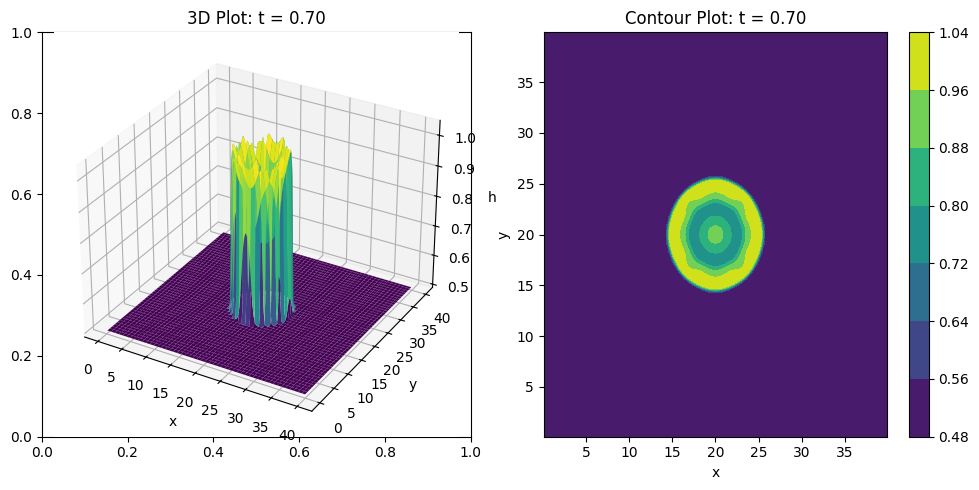

In [124]:
save = 1

# Plot the final data in 3D and in contour
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 3D Surface plot on the first subplot
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x, y)
ax1.plot_surface(X, Y, Q[0, :, :], cmap='viridis')
ax1.set_title(f'3D Plot: t = {t:.2f}')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('h')

# Contour plot on the second subplot
ax2 = axes[1]
contour = ax2.contourf(X, Y, Q[0, :, :], cmap='viridis')
fig.colorbar(contour, ax=ax2)
ax2.set_title(f'Contour Plot: t = {t:.2f}')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

plt.tight_layout()

# Save figure
if save:
    filename = f'plots/toro2D_t={tend}.png'
    plt.savefig(filename)

plt.show()

# Week 2, day 5 
Solves the Saint-Venant equations (1D problem) using different numerical fluxes.

## Functions

In [95]:
def exact_sol(mcells, hL, hR, uL, uR, coL, coR, gravit, time, xmin, xmax):
    tol = 1.E-16
    niter = 100

    h = np.zeros(mcells + 1)
    u = np.zeros(mcells + 1)
    co = np.zeros(mcells + 1)

    # Compute celerity on left and right states
    cL = np.sqrt(gravit * hL)
    cR = np.sqrt(gravit * hR)

    Hcrit = (uR - uL) - 2 * (cL + cR)  # depth positivity condition

    # Screen size for plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    dx = (xmax - xmin) / mcells
    x = np.linspace(xmin, xmax, mcells + 1)
    S = x / time

    if hL <= 0 or hR <= 0 or Hcrit >= 0:
        # Dry bed case
        if hL <= 0:
            shR = uR + cR
            stR = uR - 2 * cR

            for i in range(mcells + 1):
                if S[i] >= shR:
                    h[i] = hR
                    u[i] = uR
                elif S[i] >= stR:
                    u[i] = (uR - 2 * cR + 2 * S[i]) / 3
                    C = (-uR + 2 * cR + S[i]) / 3
                    h[i] = C**2 / gravit
                else:
                    h[i] = hL
                    u[i] = uL
        else:
            if hR <= 0:
                shL = uL - cL
                stL = uL + 2 * cL

                for i in range(mcells + 1):
                    if S[i] <= shL:
                        h[i] = hL
                        u[i] = uL
                    elif S[i] <= stL:
                        u[i] = (uL + 2 * cL + 2 * S[i]) / 3
                        C = (uL + 2 * cL - S[i]) / 3
                        h[i] = C**2 / gravit
                    else:
                        h[i] = hR
                        u[i] = uR
            else:
                shL = uL - cL
                ssL = uL + 2 * cL
                ssR = uR - 2 * cR
                shR = uR + cR

                for i in range(mcells + 1):
                    if S[i] <= shL:
                        h[i] = hL
                        u[i] = uL
                    elif shL < S[i] <= ssL:
                        u[i] = (uL + 2 * cL + 2 * S[i]) / 3
                        C = (uL + 2 * cL - S[i]) / 3
                        h[i] = C**2 / gravit
                    elif ssL < S[i] <= ssR:
                        h[i] = 0
                        u[i] = 0
                    elif ssR < S[i] <= shR:
                        u[i] = (uR - 2 * cR + 2 * S[i]) / 3
                        C = (-uR + 2 * cR + S[i]) / 3
                        h[i] = C**2 / gravit
                    else:
                        h[i] = hR
                        u[i] = uR
    else:
        # Wet bed case
        hS, uS = wetbed(hL, hR, uL, uR, cL, cR, gravit, niter, tol)
        cS = np.sqrt(gravit * hS)

        if hS >= hL:
            qL = np.sqrt((hS + hL) * hS / (2 * hL**2))
            sL = uL - cL * qL
            left = True
        else:
            shL = uL - cL
            stL = uS - cS
            left = False

        if hS >= hR:
            qR = np.sqrt((hS + hR) * hS / (2 * hR**2))
            sR = uR + cR * qR
            right = True
        else:
            shR = uR + cR
            stR = uS + cS
            right = False

        for i in range(mcells + 1):
            if S[i] < uS:
                co[i] = coL
                if left:
                    if S[i] < sL:
                        h[i] = hL
                        u[i] = uL
                    else:
                        h[i] = hS
                        u[i] = uS
                else:
                    if S[i] < shL:
                        h[i] = hL
                        u[i] = uL
                    elif S[i] < stL:
                        u[i] = (uL + 2 * cL + 2 * S[i]) / 3
                        C = (uL + 2 * cL - S[i]) / 3
                        h[i] = C**2 / gravit
                    else:
                        h[i] = hS
                        u[i] = uS
            else:
                co[i] = coR
                if right:
                    if S[i] > sR:
                        h[i] = hR
                        u[i] = uR
                    else:
                        h[i] = hS
                        u[i] = uS
                else:
                    if S[i] > shR:
                        h[i] = hR
                        u[i] = uR
                    elif S[i] > stR:
                        u[i] = (uR - 2 * cR + 2 * S[i]) / 3
                        C = (-uR + 2 * cR + S[i]) / 3
                        h[i] = C**2 / gravit
                    else:
                        h[i] = hS
                        u[i] = uS

    return h, u, co, x

def wetbed(hL, hR, uL, uR, cL, cR, gravit, niter, tol):
    # Placeholder function for wet bed case, replace with actual logic
    # Solve for hS, uS
    hS = (hL + hR) / 2  # Approximation, should be replaced
    uS = (uL + uR) / 2  # Approximation, should be replaced
    return hS, uS


In [96]:
import numpy as np

def exact_sol_adv(mcells, hL, hR, uL, uR, coL, coR, gravit, time, xmin, xmax):
    tol = 1.E-12

    h = np.zeros(mcells + 1)
    u = np.zeros(mcells + 1)
    co = np.zeros(mcells + 1)

    # Compute ratios
    R_h = hR / hL
    R_U = uL / uR if abs(uR) > tol else 0

    if uL >= 0 and uR >= 0:
        # Solution in the star region
        hS = hR
        uS = uL * np.sqrt(hL / hR)
        if R_U > np.sqrt(R_h):  # Right wave is a shock wave
            sR = uR + uS  # Shock speed
            right = True
        else:  # Right wave is a rarefaction
            shR = 2 * uR
            stR = 2 * uS
            right = False

    elif uL < 0 and uR < 0:
        # Solution in the star region
        hS = hL
        uS = -abs(uR) * np.sqrt(hR / hL)
        if R_U < np.sqrt(R_h):  # Left wave is a shock wave
            sL = uL + uS  # Shock speed
            left = True
        else:  # Left wave is a rarefaction
            shL = 2 * uL
            stL = 2 * uS
            left = False

    elif uL > 0 and uR < 0:
        if abs(R_U) < np.sqrt(R_h):  # Left wave is a shock wave
            hS = hL
            uS = -abs(uR) * np.sqrt(hR / hL)
            sL = uL + uS  # Shock speed
            left = True
        else:  # Right wave is a shock wave
            hS = hR
            uS = uL * np.sqrt(hL / hR)
            sR = uR + uS  # Shock speed
            right = True

    elif uL < 0 and uR > 0:
        uS = 0  # Transonic rarefaction
        shL = 2 * uL
        stR = 2 * uR

    # Space discretization
    dx = (xmax - xmin) / mcells
    x = np.linspace(xmin, xmax, mcells + 1)
    S = x / time

    for i in range(mcells + 1):
        if uS < -tol:
            if left:  # Left shock
                if S[i] < sL:
                    h[i] = hL
                    u[i] = uL
                elif S[i] <= 0:
                    h[i] = hS
                    u[i] = uS
                else:
                    h[i] = hR
                    u[i] = uR
            else:  # Left rarefaction
                if S[i] < shL:
                    h[i] = hL
                    u[i] = uL
                elif S[i] < stL:
                    u[i] = S[i] / 2
                    h[i] = hL
                elif S[i] <= 0:
                    h[i] = hS
                    u[i] = uS
                else:
                    h[i] = hR
                    u[i] = uR

        elif uS > tol:
            if right:  # Right shock
                if S[i] > sR:
                    h[i] = hR
                    u[i] = uR
                elif S[i] >= 0:
                    h[i] = hS
                    u[i] = uS
                else:
                    h[i] = hL
                    u[i] = uL
            else:  # Right rarefaction
                if S[i] > shR:
                    h[i] = hR
                    u[i] = uR
                elif S[i] > stR:
                    u[i] = S[i] / 2
                    h[i] = hR
                elif S[i] >= 0:
                    h[i] = hS
                    u[i] = uS
                else:
                    h[i] = hL
                    u[i] = uL

        else:  # uS = 0 (sonic rarefaction)
            if S[i] < shL:
                h[i] = hL
                u[i] = uL
            elif S[i] > stR:
                h[i] = hR
                u[i] = uR
            else:
                u[i] = S[i] / 2
                h[i] = hL if S[i] < 0 else hR

    hexact = h
    uexact = u
    coexact = co

    return hexact, uexact, coexact, x


In [97]:
def exact_speeds_FULL(hL, hR, uL, uR, cL, cR, gravit):
    tol = 1.0E-12
    niter = 100

    # Depth positivity condition (Hcrit)
    Hcrit = (uR - uL) - 2 * (cL + cR)

    # Wet bed case
    hS, uS = wetbed(hL, hR, uL, uR, cL, cR, gravit, niter, tol)

    # Left wave is a shock or rarefaction
    if hS >= hL:
        qL = np.sqrt((hS + hL) * hS / (2 * hL**2))
        sL = uL - cL * qL
    else:
        sL = uL - cL

    # Right wave is a shock or rarefaction
    if hS >= hR:
        qR = np.sqrt((hS + hR) * hS / (2 * hR**2))
        sR = uR + cR * qR
    else:
        sR = uR + cR

    return sL, sR

In [98]:
def exact_speeds_PREX(hL, hR, uL, uR, gravit):
    tol = 1.0E-6
    niter = 50

    cL = np.sqrt(gravit * hL)
    cR = np.sqrt(gravit * hR)

    # Wet bed case (depth positivity condition)
    hS, qS = wetbed_PREX(hL, hR, uL, uR, cL, cR, gravit, niter, tol)

    # Left wave is a shock or rarefaction
    if hS >= hL:
        qL = np.sqrt(0.5 * (hS / hL + 1))
        sL = -cL * qL
    else:
        sL = -cL

    # Right wave is a shock or rarefaction
    if hS >= hR:
        qR = np.sqrt(0.5 * (hS / hR + 1))
        sR = cR * qR
    else:
        sR = cR
    return sL, sR


In [99]:
def exrs_ADV(hL, hR, uL, uR):
    R_h = hR / hL
    R_U = uL / uR

    if uL >= 0 and uR >= 0:
        # Solution in the star region
        hstar = hR
        ustar = uL * np.sqrt(hL / hR)
    elif uL < 0 and uR < 0:
        # Solution in the star region
        hstar = hL
        ustar = -abs(uR) * np.sqrt(hR / hL)
    elif uL > 0 and uR < 0:
        if abs(R_U) < np.sqrt(R_h):  # Left wave is a shock wave
            # Solution in the star region
            hstar = hL
            ustar = -abs(uR) * np.sqrt(hR / hL)
        else:  # Right wave is a shock wave
            # Solution in the star region (Non funziona!!!)
            hstar = hR
            ustar = uL * np.sqrt(hL / hR)
    elif uL < 0 and uR > 0:  # Transonic rarefaction
        # Solution in the star region
        hstar = hL  # or hR; It works well with both choices
        ustar = 0

    return hstar, ustar


In [100]:
def exrs_FULL(hL, hR, uL, uR, cL, cR, gravit):
    tol = 1.0E-8
    niter = 100

    # Evaluate the flow depth and velocity in the star region using wetbed function
    hS, uS = wetbed(hL, hR, uL, uR, cL, cR, gravit, niter, tol)
    cS = np.sqrt(gravit * hS)
    
    if hS >= hL:  # Left wave is a shock wave
        qL = np.sqrt((hS + hL) * hS / (2 * hL ** 2))
        sL = uL - cL * qL
        left = 1
    else:  # Left wave is a rarefaction
        shL = uL - cL
        stL = uS - cS
        left = 0

    if hS >= hR:  # Right wave is a shock
        qR = np.sqrt((hS + hR) * hS / (2 * hR ** 2))
        sR = uR + cR * qR
        right = 1
    else:  # Right wave is a rarefaction
        shR = uR + cR
        stR = uS + cS
        right = 0

    S = 0  # Assuming S is the star region speed
    
    # Check left wave condition
    if S < uS:
        if left == 1:
            if S < sL:
                hstar = hL
                ustar = uL
            else:
                hstar = hS
                ustar = uS
        else:
            if S < shL:
                hstar = hL
                ustar = uL
            else:
                if S < stL:
                    ustar = (uL + 2 * cL + 2 * S) / 3
                    C = (uL + 2 * cL - S) / 3
                    hstar = C ** 2 / gravit
                else:
                    hstar = hS
                    ustar = uS
    # Check right wave condition
    else:
        if right == 1:
            if S > sR:
                hstar = hR
                ustar = uR
            else:
                hstar = hS
                ustar = uS
        else:
            if S > shR:
                hstar = hR
                ustar = uR
            else:
                if S > stR:
                    ustar = (uR - 2 * cR + 2 * S) / 3
                    C = (-uR + 2 * cR + S) / 3
                    hstar = C ** 2 / gravit
                else:
                    hstar = hS
                    ustar = uS

    return hstar, ustar


In [101]:
def fun_qk(hs, hk):
    y = hs / hk
    qk = np.sqrt(0.5 * (y**2 + y))
    return qk


In [102]:
def geofun(he, hk, ck, gravit):
    if he <= hk:  # wave is a rarefaction wave
        c = np.sqrt(gravit * he)
        f = 2 * (c - ck)
        fd = gravit / c
    else:  # wave is a shock
        ges = np.sqrt(0.5 * gravit * (he + hk) / (he * hk))
        f = (he - hk) * ges
        fd = ges - 0.25 * gravit * (he - hk) / (ges * he**2)
    
    return f, fd


In [103]:
def geofun_PREX(he, hk, ak, gravit):
    if he <= hk:  # wave is a rarefaction wave
        a = np.sqrt(gravit * he)
        f = (2 / 3) * (he * a - hk * ak)
        fd = a
    else:  # wave is a shock
        ges = np.sqrt(0.5 * gravit * (he + hk))
        f = (he - hk) * ges
        fd = np.sqrt(gravit / 8) * (3.0 * he + hk) / np.sqrt(he + hk)
    
    return f, fd


In [104]:
def hll(hL, hR, uL, uR, aL, aR, gravit):
    hstar = (((aL + aR) / 2 + (uL - uR) / 4) ** 2) / gravit
    
    if hstar > hL:
        qL = np.sqrt(0.5 * (hstar + hL) * hstar / (hL ** 2))
    else:
        qL = 1
    
    if hstar > hR:
        qR = np.sqrt(0.5 * (hstar + hR) * hstar / (hR ** 2))
    else:
        qR = 1
    
    SL = uL - aL * qL
    SR = uR + aR * qR
    
    return SL, SR


In [105]:
def two_rar_approx_PREX(hL, hR, qL, qR, gravit):
    tol = 1.0E-12
    cL = np.sqrt(gravit * hL)
    cR = np.sqrt(gravit * hR)
    
    # Two rarefaction solution as starting value
    hS2 = (0.75 / np.sqrt(gravit) * (qL - qR) + 0.5 * (hL ** 1.5 + hR ** 1.5)) ** 2
    hS = hS2 ** (1. / 3.)
    
    if hS < tol:
        hS = tol
    
    qS = 0.5 * (qL + qR) + np.sqrt(gravit) / 3 * (hL ** 1.5 - hR ** 1.5)
    
    if abs(qS) < tol:
        qS = np.sign(qS) * tol
    
    return hS, qS


In [106]:
def wetbed(hL, hR, uL, uR, cL, cR, gravit, niter, tol):
    # Use two rarefaction solution as starting value
    hS = (1 / gravit) * (0.5 * (cL + cR) - 0.25 * (uR - uL)) ** 2
    
    h0 = hS
    cha = 1
    
    for i in range(niter):
        fL, fLd = geofun(hS, hL, cL, gravit)
        fR, fRd = geofun(hS, hR, cR, gravit)
        
        hS = hS - (fL + fR + uR - uL) / (fLd + fRd)
        
        cha = abs(hS - h0) / (0.5 * (hS + h0))
        
        if cha < tol:
            break
        
        if hS < 0:
            hS = tol
        
        h0 = hS
    
    uS = 0.5 * (uL + uR) + 0.5 * (fR - fL)
    
    return hS, uS


## Solve the 1D SWE

In [107]:
# Constants
SMALL = 1.E-12
a = 0  # Left boundary
b = 50  # Right boundary
gate = (a + b) / 2  # Gate position for the dambreak

# Condition: the gate must be within the domain [a, b]
if gate > b:
    raise ValueError("Error: gate > b")

# Discretization parameters
mcells = 200  # Number of cells for numerical simulations

# Flux choice
# 1 --> Godunov method with exact Riemann problem
# 2 --> Lax-Friedrichs
# 3 --> Lax-Wendroff
# 4 --> FORCE
# 5 --> HLLC
# 6 --> Flux-splitting (2020) UPWIND: this is our method!!!
iflux = 5

gravit = 9.8  # Gravity
ntmaxi = 100000  # Maximum number of time cycles
timeout = 6  # Final time for computation
cfl = 0.9  # Courant number (choose cfl <1 for stable solutions)

# Initial conditions for simulations
itest = 2  # Test case number

# Define initial conditions based on the test case
if itest == 1:  # Left rarefaction - Right shock
    gate = 10.0
    h_init_L = 1.0
    h_init_R = 0.1
    UL = 2.5
    UR = 0.0
    timeout = 7.0
elif itest == 2:  # Left rarefaction - Right shock
    gate = 25.0
    h_init_L = 1.0
    h_init_R = 1.0
    UL = -5.0
    UR = 5.0
    timeout = 2.5
elif itest == 3:  # Two-shocks
    gate = 20.0
    h_init_L = 1.0
    h_init_R = 0.0005
    UL = 0.0
    UR = 0.0
    timeout = 4.0
elif itest == 4:  # Two rarefactions
    gate = 30.0
    h_init_L = 0.005
    h_init_R = 1.0
    UL = 0.0
    UR = 0.0
    timeout = 4.0
elif itest == 5:  # Two rarefactions (Red sea)
    gate = 25.0
    h_init_L = 0.1
    h_init_R = 0.1
    UL = -3.0
    UR = 3.0
    timeout = 5.0

# Discretization parameters
dx = (b - a) / mcells  # Spatial step
igate = round((gate - a) / dx)  # Index at which the gate is positioned
x = np.arange(a, b + dx, dx)  # Interface coordinate
xc = x[:mcells] + dx / 2  # Cell center coordinate

# Set initial conditions
h = np.zeros(mcells)
Q = np.zeros(mcells)
h[:igate] = h_init_L
Q[:igate] = h_init_L * UL
h[igate:] = h_init_R
Q[igate:] = h_init_R * UR

flux = np.zeros((2, mcells + 1))
flux_ADV = np.zeros((2, mcells + 1))
flux_PREX = np.zeros((2, mcells + 1))

# Time marching procedure
time = 0
for t in range(1, ntmaxi + 1):
    # Compute eigenvalues
    lambda_ = np.zeros((2, mcells))
    lambda_[0, :] = Q / h - np.sqrt(gravit * h)
    lambda_[1, :] = Q / h + np.sqrt(gravit * h)

    # Compute maximum eigenvalue for the Courant condition
    lambdamax = np.max(np.abs(lambda_))
    
    # Set the time step dt
    dt = cfl * dx / lambdamax
    if t < 10:
        dt = dt * 0.2

    # Calculate numerical fluxes
    for i in range(1, mcells):
        hL = h[i - 1]
        hR = h[i]
        uL = Q[i - 1] / h[i - 1]
        uR = Q[i] / h[i]
        qL = Q[i - 1]
        qR = Q[i]
        aL = np.sqrt(gravit * hL)
        aR = np.sqrt(gravit * hR)

        if iflux == 1:  # Godunov
            hstar, ustar = exrs_FULL(hL, hR, uL, uR, aL, aR, gravit)
            flux[0, i] = hstar * ustar
            flux[1, i] = ustar**2 * hstar + 0.5 * gravit * hstar**2

        elif iflux == 2:  # Lax-Friedrichs
            FL = np.array([hL * uL, uL**2 * hL + 0.5 * gravit * hL**2])
            FR = np.array([hR * uR, uR**2 * hR + 0.5 * gravit * hR**2])

            flux[0, i] = 0.5 * (FL[0] + FR[0]) - 0.5 * dx / dt * (hR - hL)
            flux[1, i] = 0.5 * (FL[1] + FR[1]) - 0.5 * dx / dt * (hR * uR - hL * uL)

        elif iflux == 3:  # Lax-Wendroff
            FL = np.array([hL * uL, uL**2 * hL + 0.5 * gravit * hL**2])
            FR = np.array([hR * uR, uR**2 * hR + 0.5 * gravit * hR**2])

            hLW = 0.5 * (hL + hR) - 0.5 * dt / dx * (FR[0] - FL[0])
            QLW = 0.5 * (uL * hL + uR * hR) - 0.5 * dt / dx * (FR[1] - FL[1])
            uLW = QLW / hLW

            flux[0, i] = hLW * uLW
            flux[1, i] = uLW**2 * hLW + 0.5 * gravit * hLW**2

        elif iflux == 5:  # HLL Flux
            SL, SR = hll(hL, hR, uL, uR, aL, aR, gravit)
            ustar = 0.5 * (uL + uR) + aL - aR

            FL = np.array([hL * uL, uL**2 * hL + 0.5 * gravit * hL**2])
            FR = np.array([hR * uR, uR**2 * hR + 0.5 * gravit * hR**2])

            Fhhl = (SR * FL - SL * FR + SR * SL * (np.array([hR, hR * uR]) - np.array([hL, hL * uL]))) / (SR - SL)

            if SL >= 0:
                flux[:, i] = FL
            elif SR <= 0:
                flux[:, i] = FR
            else:
                flux[:, i] = Fhhl

    # Transmissive boundary conditions
    flux[:, 0] = flux[:, 1]  # Left boundary
    flux[:, mcells] = flux[:, mcells - 1]  # Right boundary

    # Update formula
    h = h - dt / dx * (flux[0, 1:mcells + 1] - flux[0, :mcells])
    Q = Q - dt / dx * (flux[1, 1:mcells + 1] - flux[1, :mcells])

    u = Q / h
    Fr = u / np.sqrt(gravit * h)

    hmax = np.max(h) * 1.2
    hmin = np.min(h) * 0.8

    # Plotting results
    if time >= timeout:
        umax = np.max(u) * 1.2
        umin = np.min(u)

        plt.subplot(2, 1, 1)
        plt.plot(xc, h, 'o')
        plt.title(f'Water height at time = {timeout} s')
        plt.xlabel('x')
        plt.ylabel('h')

        plt.subplot(2, 1, 2)
        plt.plot(xc, Q / h, 'o')
        plt.title(f'Velocity at time = {timeout} s')
        plt.xlabel('x')
        plt.ylabel('u')

        plt.show


KeyboardInterrupt: 